## Plots metagene binding profiles as heatmaps

In [1]:
import itertools
import sys
import numpy as np
import pandas as pd
import os
import collections
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.gridspec as gridspec

#### set these global parameters:

In [2]:
home_dir = '/home/salma/Coding/scratch'

pipeline_dir = os.path.join(home_dir, 'pipeline')
plotting_dir = os.path.join(home_dir, 'plots/metagene_heatmaps/')

pathways_of_interest = ['Surveillance', 'Deadenylation', 'Decapping', 'Xrn1', 'Exosome', 'TRAMP', 'Ski',  'NMD']
colors = ['purple', 'r', 'g', 'xkcd:orange', '#0000FF', '#1E90FF', '#87CEEB', '#C2BC87']

#profiles computed by mockinbird

#sense strand
sense_filename_TSS = 'non_overlapping_TSS/TIF_NoOv_sense_TSS_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'
sense_filename_pA = 'non_overlapping_pA/TIF_NoOv_sense_pA_centerBoth_up1000_gene750_do1000_min1000_max5000_sense.table'

#antisense strand
asense_filename_TSS = 'non_overlapping_TSS/TIF_NoOv_asense_TSS_centerBoth_up1000_gene750_do1000_min1000_max5000_asense.table'
asense_filename_pA = 'non_overlapping_pA/TIF_NoOv_asense_pA_centerBoth_up1000_gene750_do1000_min1000_max5000_asense.table'

#marked positions on profiles based on mockinbird interval parameters 
vlinepos = [1, 1000, 1751, 2501, 3499]
labels = ['-1000', 'TSS', 'Gene Body', 'pA', '+1000']

In [3]:
#load data list
data_summary = pd.read_table(os.path.join(home_dir, 'data_summary_detailed.txt'), header=None)

data_summary.columns=['factor','pathway','group']
data_summary.index = data_summary.factor

factors = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'factor']
groups = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'group']
pathways = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'pathway']
lut = dict(zip(pathways.unique(), colors))

pw_colors = [lut[x] for x in pathways]

In [4]:
#read profiles from file: 
def read_profiles(filename, factors):  
    profiles = list()
    for fac in factors:
        with open(os.path.join(pipeline_dir , fac, 'postprocess', filename)) as f:
            profiles.append([float(i) for i in f.readlines()[0].split()])

    profiles = pd.DataFrame(profiles, index=factors)        
    normalized_profiles = profiles.apply(lambda x: ((x-min(x))/(max(x)-min(x))), axis=1) 
    normalized_profiles.index = [s.split('-')[0] for s in normalized_profiles.index]

    return normalized_profiles

normalized_sense_profiles_TSS  = read_profiles(sense_filename_TSS, factors)
normalized_sense_profiles_pA  = read_profiles(sense_filename_pA, factors)
normalized_asense_profiles_TSS = read_profiles(asense_filename_TSS, factors)
normalized_asense_profiles_pA  = read_profiles(asense_filename_pA , factors)

In [5]:
#plot the profiles
#profiles from the pipeline have 1000 down/upstream and 750 in gene body
#skip parameter controls the rage of plotting: here we set it to -+700 around TSS and pA


def plot_metagene_heatmap(filename, sense=True, cmap='RdYlBu_r', savefile = False, line_colour='black', skip_out=0, skip_in=0):
    
    sns.set_style("ticks")
    vlinepos_lf = [0, 1000-skip_out]
    vlinepos_rt = [751-skip_in, 1750-skip_out]

    figw = 6
    figh = len(factors)*0.3

    height_ratios = [sum(data_summary.pathway==p) for p in pathways_of_interest]

    gridspec_kw = {"height_ratios":height_ratios, "width_ratios":[1,1]}
    heatmapkws = dict(square=False, cbar=False, cmap = cmap, linewidths=0.0, vmin=0.05, vmax=0.95) 
    tickskw =  dict(xticklabels=False, yticklabels=True)

    left = 0.07; right=0.87
    bottom = 0.1; top = 0.9

    fig, axes = plt.subplots(ncols=2, nrows=len(height_ratios), figsize=(figw, figh), gridspec_kw=gridspec_kw)
    plt.subplots_adjust(left=left, right=right,bottom=bottom, top=top, wspace=0.02, hspace=0.10)

    cumsum = np.cumsum(height_ratios)

    w = len(normalized_sense_profiles_TSS.iloc[0,:])

    #left
    if sense:
        profiles = normalized_sense_profiles_TSS
    else:
        profiles = normalized_asense_profiles_TSS
        
    sns.heatmap(profiles.iloc[0:cumsum[0],skip_out:(int(w/2 +1)-skip_in)], ax=axes[0,0], xticklabels=False, 
                yticklabels=False, rasterized=True, robust=True, **heatmapkws)

    for i in range(1,len(cumsum)):    
        sns.heatmap(profiles.iloc[cumsum[i-1]:cumsum[i],skip_out:(int(w/2 +1)-skip_in)], ax=axes[i,0], xticklabels=False, 
                    yticklabels=False, rasterized=True, robust=True, **heatmapkws)

    for i in range(len(cumsum)):
        axes[i,0].vlines(vlinepos_lf[0], *axes[i,0].get_ylim())
        axes[i,0].vlines(vlinepos_lf[1], *axes[i,0].get_ylim(), color=line_colour, linewidth=3)
        axes[i,0].hlines(list(axes[i,0].get_ylim()), *axes[i,0].get_xlim())
        axes[i,0].set_visible(True)
        axes[i,0].vlines([1751-skip_out-skip_in], *axes[i,0].get_ylim(), linestyles='-', colors='White')
        axes[i,0].vlines([1751-skip_out-skip_in], *axes[i,0].get_ylim(), linestyles='dashed')


    #right
    if sense:
        profiles = normalized_sense_profiles_pA
    else:
        profiles = normalized_asense_profiles_pA
    
    sns.heatmap(profiles.iloc[0:cumsum[0],(int(w/2 +1)+skip_in):w-skip_out+skip_in], ax=axes[0,1], xticklabels=False, 
                yticklabels=True, rasterized=True, robust=True, **heatmapkws)

    for i in range(1,len(cumsum)):    
        sns.heatmap(profiles.iloc[cumsum[i-1]:cumsum[i],(int(w/2 +1)+skip_in):w-skip_out+skip_in], ax=axes[i,1], xticklabels=False, 
                    yticklabels=True, rasterized=True, robust=True, **heatmapkws)

    for i in range(len(cumsum)):
        axes[i,1].vlines(vlinepos_rt, *axes[i,1].get_ylim())
        axes[i,1].vlines(vlinepos_rt[0], *axes[i,1].get_ylim(), color=line_colour, linewidth=3)
        axes[i,1].hlines(list(axes[i,1].get_ylim()), *axes[i,1].get_xlim())
        axes[i,1].set_visible(True)
        axes[i,1].yaxis.tick_right()
        axes[i,1].yaxis.set_label_position('right')
        axes[i,1].set_yticklabels(labels=axes[i,1].get_yticklabels() , rotation=0, fontsize=12) #weight='bold'
        axes[i,1].vlines([0], *axes[i,0].get_ylim(), linestyles='-', linewidth=2, colors='white')
        axes[i,1].vlines([0], *axes[i,0].get_ylim(), linestyles='--', linewidth=2, colors='black')
        

    if savefile:
        plt.savefig(os.path.join(plotting_dir, filename), bbox_inches='tight')
    plt.show()

### sense strand

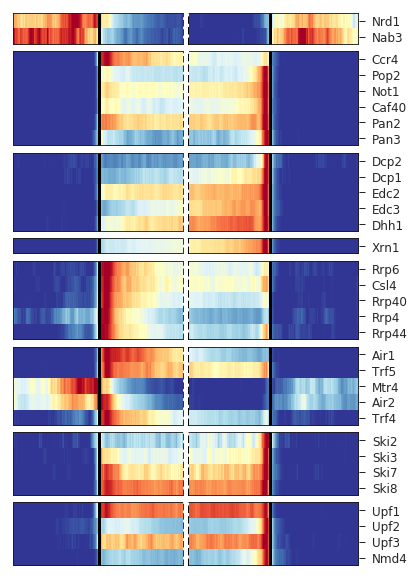

In [6]:
plot_metagene_heatmap(sense=True, filename= 'sense.pdf', cmap='RdYlBu_r', savefile = False, skip_out=300, skip_in=50)

### anti-sense strand

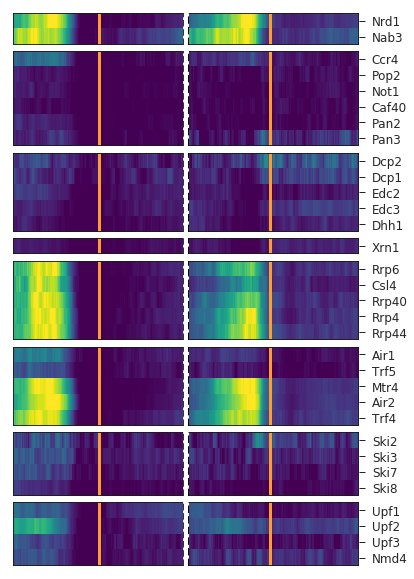

In [7]:
plot_metagene_heatmap (sense=False, filename= 'asense.pdf', 
                       cmap='viridis', savefile = False, line_colour='#ff9e2e', skip_out=300, skip_in=50)